In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings(action='ignore')

# Text processing and vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Pipeline and transformers
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Model training and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

In [2]:
covid_clean =pd.read_csv(r'C:/Users/chand/Downloads/606/covid_ML.csv')

In [3]:
custom_stopwords = nltk.corpus.stopwords.words('english')

stopword_list = ['moderna', 'flu', 'mrna', 'vaccine', 'the', 'patient', 'pfizer', 
                 'biontech', 'nan', 'none', 'mg', 'medical', 'history', 'allergy', 
                 'year', 'old','uk','nkda','nka','known','reported','listed']

In [4]:
textTransformer_0 = Pipeline(steps=[
    ('text_bow', TfidfVectorizer(lowercase=True,\
                                 token_pattern=r"(?u)\b\w+\b",\
                                 stop_words=stopword_list,
                                 ngram_range=(2, 2),max_features=5000))])

In [5]:
tfidfprocess = ColumnTransformer(transformers=[('text1', textTransformer_0, 'SYMPTOM_TEXT'),
                                              ('text2', textTransformer_0, 'OTHER_MEDS'),
                                              ('text3', textTransformer_0, 'CUR_ILL'),
                                              ('text4', textTransformer_0, 'HISTORY'),
                                              ('text5', textTransformer_0, 'ALLERGIES')
],remainder='passthrough')

In [11]:
vaccine_data = pd.get_dummies(covid_clean.VAX_MANU)
covid_clean = pd.merge(covid_clean, vaccine_data, left_index=True, right_index=True)
covid_clean.rename(columns = {'JANSSEN':'JANSSEN','MODERNA': 'MODERNA', 'NOVAVAX':'NOVAVAX', 'PFIZER\BIONTECH': 'PFIZER'}, inplace = True)


In [13]:
covid_clean.OTHER_MEDS = covid_clean.OTHER_MEDS.replace(np.nan,'',regex=True)
covid_clean.CUR_ILL = covid_clean.CUR_ILL.replace(np.nan,'',regex=True)
covid_clean.HISTORY = covid_clean.HISTORY.replace(np.nan,'',regex=True)
covid_clean.ALLERGIES = covid_clean.ALLERGIES.replace(np.nan,'',regex=True)
     


In [17]:
from sklearn.model_selection import train_test_split

y= covid_clean.SERIOUS
X= covid_clean.drop(['SERIOUS','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4',
                    'SYMPTOM5','VAX_MANU'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=200, stratify=y)

print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 620,627
Test examples: 265,983


In [19]:
pipeline_logistic = Pipeline([
    ('tfidf', tfidfprocess),  # Use the TF-IDF transformer
    ('classifier', LogisticRegression(max_iter=1000, random_state=200))
])

In [21]:
pipeline_logistic.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text1',
                                                  Pipeline(steps=[('text_bow',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(2,
                                                                                                2),
                                                                                   stop_words=['moderna',
                                                                                               'flu',
                                                                                               'mrna',
                                                                                               'vaccine',
                                                                                               'the',
                                                                                               'patient',
                                                                                               'pfizer',
                                                                                               'biontech',
                                                                                               'nan',
                                                                                               'none',
                                                                                               'mg',
                                                                                               'medical',
                                                                                               'history',
                                                                                               'allergy',
                                                                                               'year',
                                                                                               'old',
                                                                                               'uk',
                                                                                               'nkda',
                                                                                               'nka',
                                                                                               'known',
                                                                                               'reported',
                                                                                               '...
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(2,
                                                                                                2),
                                                                                   stop_words=['moderna',
                                                                                               'flu',
                                                                                               'mrna',
                                                                                               'vaccine',
                                                                                               'the',
                                                                                               'patient',
                                                                                               'pfizer',
                                                                                               'biontech',
                                                      

In [22]:
# Predict on the test data
y_pred_log = pipeline_logistic.predict(X_test)

In [23]:
# Evaluate the logistic regression model
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

Logistic Regression:
Accuracy: 0.9406879387028494
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96    203584
           1       0.95      0.79      0.86     62399

    accuracy                           0.94    265983
   macro avg       0.95      0.89      0.91    265983
weighted avg       0.94      0.94      0.94    265983

Confusion Matrix:
 [[201157   2427]
 [ 13349  49050]]


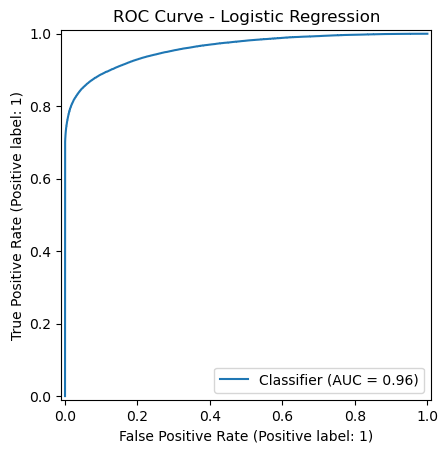

In [24]:
# Plot ROC Curve
y_proba_log = pipeline_logistic.predict_proba(X_test)[:, 1] 
RocCurveDisplay.from_predictions(y_test, y_proba_log)
plt.title("ROC Curve - Logistic Regression")
plt.show()

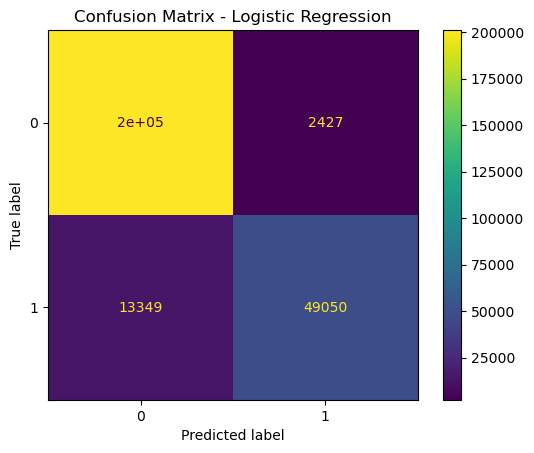

In [25]:
# Plot Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()